In [ ]:
#----------------------------------------------------------------------------
# Created By  : Tushar Mehta
# Created Date: 27/02/2023
# version ='1.0'
# ---------------------------------------------------------------------------

In [102]:
# importing all necessary libraries.
import glob
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation

In [103]:
imagePath = r"C:\Users\Tushar\PycharmProjects\Roof\images"
labelPath = r"C:\Users\Tushar\PycharmProjects\Roof\labels"

In [104]:
def sort_train_test_images(imagePath, labelPath):
    ''' 
    Input: image path and label path 

    Output: Images names of train and test images and arrays of train, test and labels
    '''
    images1 = glob.glob(imagePath + "/" + "*.png") # getting all the image names with their whole directory path.
    images = [i.split("\\")[-1] for i in images1] # splitting and saving the image name in a list.
    labels1 = glob.glob(labelPath + "/" + "*.png") # doing the same with labels
    labels = [l.split("\\")[-1] for l in labels1]
    trainImages = [] 
    testImages = []
    Y_train = np.asarray([np.asarray((cv2.threshold(cv2.imread(i, cv2.IMREAD_GRAYSCALE), 200, 255, cv2.THRESH_BINARY))[1]) for i in labels1])
    # Y_train = np.asarray([cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in labels1])
    # we have the labels in array format in 0 and 255.
    
    for i in range(len(images)): # splitting the train and test images.
        if images[i] in labels:
            trainImages.append(images1[i])
        else:
            testImages.append(images1[i])
    X_train = np.asarray([np.asarray(cv2.imread(i)) for i in trainImages]) # Image in array form.
    X_test = np.asarray([np.asarray(cv2.imread(i)) for i in testImages])

    return trainImages, testImages, X_train, X_test, Y_train


trainimages, testImages, X_train, X_test, Y_train = sort_train_test_images(imagePath, labelPath)
Y_train = Y_train.reshape((-1, 256, 256, 1)) #reshaping the array to the shape from (256,256) to (256,256,1). 
Y_train = Y_train/255 # making the image in 0 and 1 format.


In [105]:
# The required model
def roof_model(input_shape=(256, 256, 3), num_classes=1):
    '''
    Input: Input shape of the train images and no. of classes which in our case is 1 since we need 
           just background and roof. 
    
    Output: The required model to detect Rooftops.
    '''
    # Taking ResNet50 as the base model.
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Using the last layer of ResNet50 as the encoding layer
    encoder = base_model.layers[-1].output

    # Decoder layers
    # upsampling the first layer
    up1 = UpSampling2D(size=(2, 2))(encoder)
    # concatenating the Upsampled layer with a layer of ResNet50 of same size.
    up1 = Concatenate(axis=-1)([base_model.layers[142].output, up1])
    # The 2 further Conv2D layers are used to create a feature map which is then used in the next layer.
    conv1 = Conv2D(256, (3, 3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(256, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    up2 = UpSampling2D(size=(2, 2))(conv1)
    up2 = Concatenate(axis=-1)([base_model.layers[61].output, up2])
    conv2 = Conv2D(128, (3, 3), padding='same')(up2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    
    up3 = UpSampling2D(size=(2, 2))(conv2)
    up3 = Concatenate(axis=-1)([base_model.layers[13].output, up3])
    conv3 = Conv2D(64, (3, 3), padding='same')(up3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Concatenate(axis=-1)([base_model.layers[4].output, up4])
    conv4 = Conv2D(32, (3, 3), padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(32, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Concatenate(axis=-1)([base_model.layers[0].output, up5])
    conv5 = Conv2D(16, (3, 3), padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(16, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    
    # The last layer
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=base_model.input, outputs=output)

    # Freezing all layers in the base ResNet50 model
    for layer in base_model.layers:
        layer.trainable = False
    # Compiling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [141]:
model = roof_model()
# print(model.summary())


In [143]:
# training the model on train images with labels.
model.fit(X_train, Y_train, epochs=8, steps_per_epoch=4, validation_split=0.25)
# 1st run epochs=18, steps_per_epoch=4
# 2nd run epochs=8, steps_per_epoch=4 (retraining the model)

Epoch 1/8
4/4 [==============================] - 12s 3s/step - loss: 0.2434 - accuracy: 0.9869 - val_loss: 0.5213 - val_accuracy: 0.9261
Epoch 2/8
4/4 [==============================] - 11s 3s/step - loss: 0.2385 - accuracy: 0.9865 - val_loss: 0.8169 - val_accuracy: 0.8807
Epoch 3/8
4/4 [==============================] - 13s 3s/step - loss: 0.2296 - accuracy: 0.9880 - val_loss: 0.5310 - val_accuracy: 0.9298
Epoch 4/8
4/4 [==============================] - 12s 3s/step - loss: 0.2274 - accuracy: 0.9873 - val_loss: 0.5082 - val_accuracy: 0.9316
Epoch 5/8
4/4 [==============================] - 12s 3s/step - loss: 0.2170 - accuracy: 0.9894 - val_loss: 0.4540 - val_accuracy: 0.9354
Epoch 6/8
4/4 [==============================] - 12s 3s/step - loss: 0.2131 - accuracy: 0.9890 - val_loss: 0.3946 - val_accuracy: 0.9451
Epoch 7/8
4/4 [==============================] - 13s 3s/step - loss: 0.2104 - accuracy: 0.9885 - val_loss: 0.3354 - val_accuracy: 0.9538
Epoch 8/8
4/4 [==========================

In [144]:
# Predicting on the test images using the trained model
predictions = model.predict(X_test)
# changing the pixels values back in the integer form
predictions = (predictions*255).astype(np.uint8) 
# print(predictions[1].shape)

1/1 [==============================] - 2s 2s/step


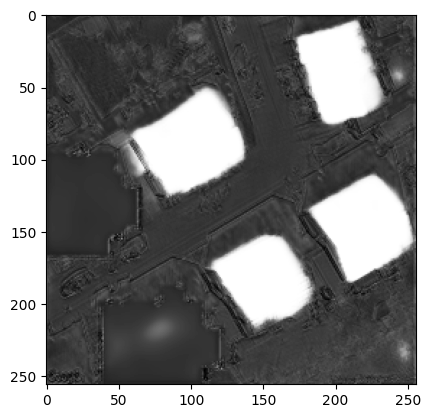

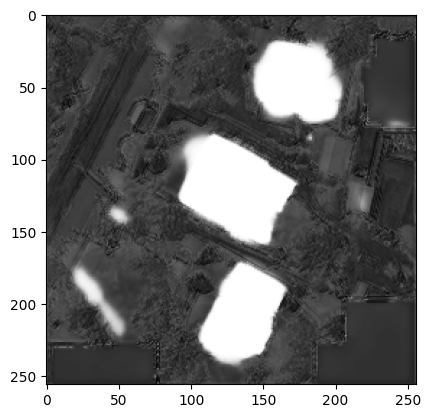

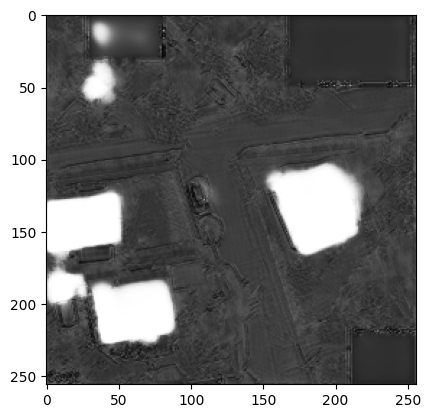

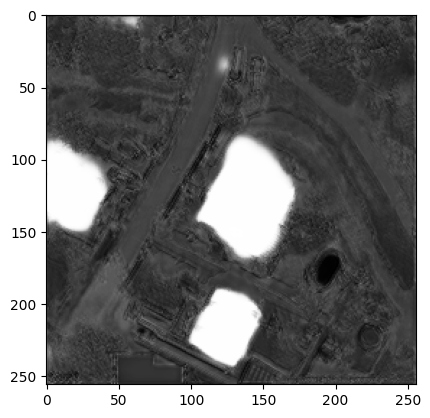

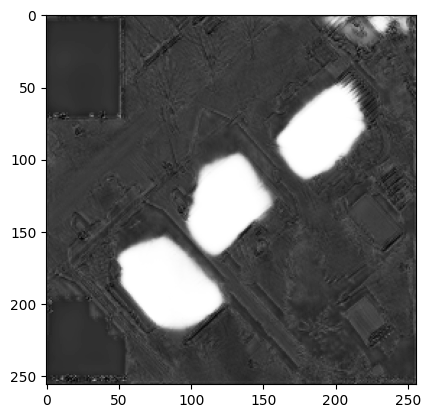

In [148]:
# Display the predictions
for i in range(len(predictions)):
    im = Image.fromarray(predictions[i][:, :, 0]) # [:, :, 0] = using the first 2 dimensions for the image.
    plt.imshow(im, cmap='gray')
    im.save("prediction"+ str(i) + ".png") # saving the predicted image
    plt.show()

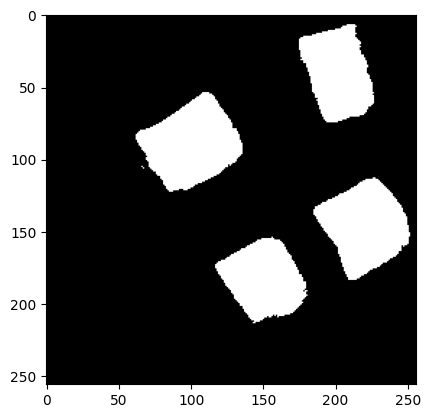

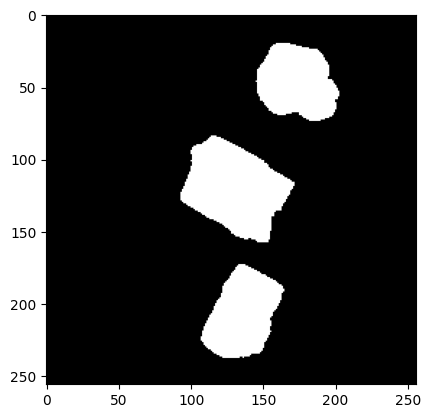

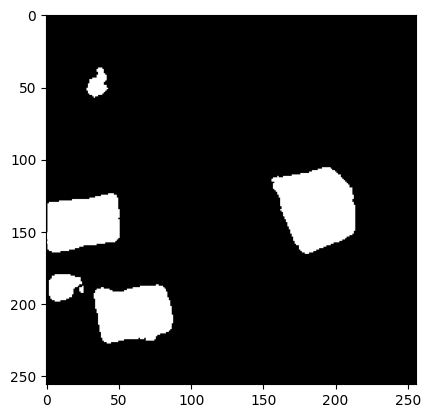

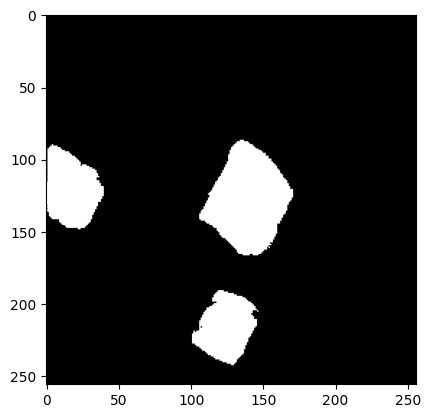

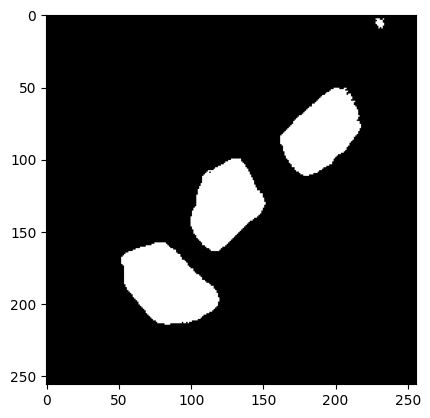

In [149]:
for i,j in zip(predictions, range(5)):
    # threshold the image to get the output as a black and white image.
    im = cv2.threshold(i, 242, 255, cv2.THRESH_BINARY)[1]
    plt.imshow(im, cmap='gray')
    im = Image.fromarray(im) 
    im.save("final"+ str(j) + ".png") # saving the threshold image
    plt.show()

In [150]:
model.save("RoofDetection.h5")